# Kernel PCA

In [84]:
import numpy as np
import pandas as pd
import polars as pl
from itertools import accumulate
import polars.selectors as ps

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

sns.set_context('notebook')
sns.set_style('white')

The idea behind Kernel PCA is to use normal PCA on a higher dimensional vector space. This is done by applying a kernel to the original input data that is then fitted with the PCA procedure.

When we have *N* datapoints, and *d* features (dimensions of our data) then in general, all points cannot be linearly separated. However with d >= N, this is possible. Usually we have large datasets, where d << N, so transforming the data to a higher dimensional space is worth checking out to evaluate separability.

We could do this explicitly by transforming the data to this higher dimensional space with a function $\Phi$, but generally $\Phi$ is an unknown function that is extremely hard to calculate. So instead we use the *Kernel Trick*. Instead of using $\Phi$ explicitly, we can use a *kernel*, which is a weighting function that can be applied to the input data as a shortcut to reach into the higher dimensional space.

The key point behind this is that usually all we need to perform machine learning is the inner product. So if we could keep our algorithm confined to only rely on the inner product of datapoints in the higher dimensional space, then we could use the following expression

$$
\mathcal{k}(a, b) = \left< \Phi(a), \Phi(b)\right>
$$

where $\left< \Phi(a), \Phi(b)\right>$ is a proper inner product of the higher dimensional space and $\mathcal{k}$ is our kernel function. As you can see, we can simply apply the kernel in this case and avoid having to transform the data first. Then we can run PCA over this *kernelised* dataset, giving us the decomposition in a higer-dimensional space.

In [28]:
## HELPER FUNCTIONS
def plot_proj(A,v,y,name=None):
    
    _, ax = plt.subplots()

    # Scatter original data
    ax.scatter(A[:,0],A[:,1],label='data',c=y,cmap='viridis')
    
    # Plot component vector
    ax.plot(
        np.linspace(-1,1),
        np.linspace(-1,1)*(v[1]/v[0]),
        color='black',
        linestyle='--',
        linewidth=1.5,
        label=name)  
    # Run through all the data

    for i in range(len(A[:,0])-1):
        #data point 
        w=A[i,:]

        # projection
        cv = (np.dot( A[i,:],v))/np.dot(v,np.transpose(v))*v

        # line between data point and projection
        ax.plot([A[i,0],cv[0]],[A[i,1],cv[1]],'r--',linewidth=1.5)
    ax.plot([A[-1,0],cv[0]],[A[-1,1],cv[1]],'r--',linewidth=1.5,label='projections' )
    ax.legend()
    ax.set_xlim([np.min(A[:,0]), np.max(A[:,0])])
    ax.set_ylim([np.min(A[:,1]), np.max(A[:,1])])
    ax.set_aspect('equal', 'box')
    return ax

## Visual Example

Below we run basic PCA on a dataset that is not linearlisable in the number of dimensions provided as features. This is a case where N >> d, and thus we have the chance of not being able to linearly separate our datapoints.

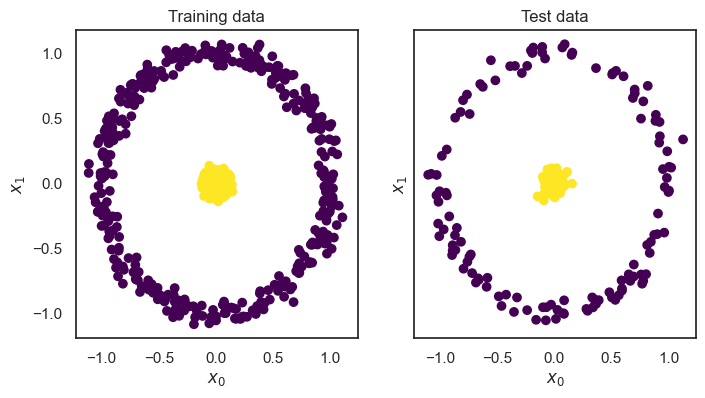

In [9]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# Create the toy dataset
X, y = make_circles(n_samples=1000, factor=0.01, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# Visualize the data
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,cmap='viridis')
train_ax.set_xlabel("$x_{0}$")
train_ax.set_ylabel("$x_{1}$")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test,cmap='viridis')
test_ax.set_xlabel("$x_{0}$")
test_ax.set_ylabel("$x_{1}$")
test_ax.set_title("Test data")
plt.show()

### Applying PCA naively

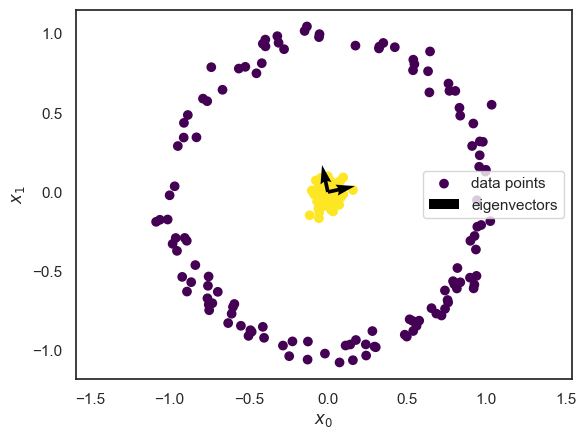

In [18]:
from sklearn.decomposition import PCA

# Fit on a PCA object
pca = PCA(n_components=2)

score_pca = pca.fit(X_train).transform(X_test)

plt.scatter(score_pca[:, 0], score_pca[:, 1], c=y_test,label="data points", cmap='viridis')
plt.quiver([0,0],[0,0], pca.components_[0,:], pca.components_[1,:], label="eigenvectors")
plt.xlabel("$x_{0}$")
plt.ylabel("$x_{1}$")
plt.legend(loc='center right')
plt.gca().axis('equal')
plt.show()

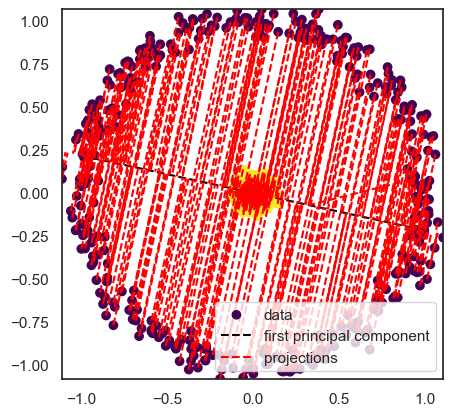

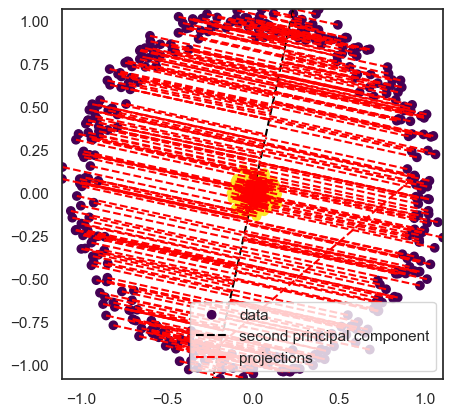

In [29]:
(
    plot_proj(X_train, pca.components_[0,:], y_train, "first principal component"),
    plot_proj(X_train, pca.components_[1,:], y_train, "second principal component")
);

From this we can clearly see the problem, each component is selected based on variance of the original data. And since the variance is equal in all directions due to the circular data, the algorithm is not capable of selecting a good decomposition. Each direction is degenerate (though due to the slight randomisation in the input data, there are probably a few minor preferential directions.)

Below this is illustrated by plotting the projection of the data onto each component, again it clearly shows that PCA cannot decompose the data into anything that is useful for classification.

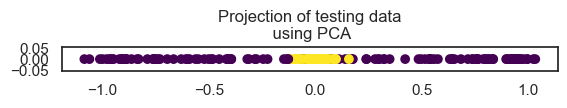

In [34]:
plt.scatter(score_pca [:,0],np.zeros(score_pca[:,0].shape[0]),c=y_test,cmap='viridis')
plt.title("Projection of testing data\n using PCA")
plt.gca().set_aspect('equal')
plt.show()

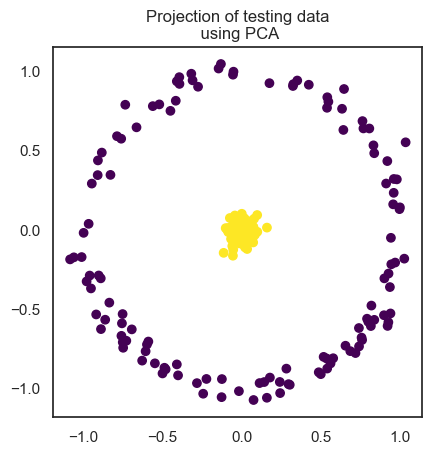

In [32]:
plt.scatter(score_pca[:, 0], score_pca[:, 1], c=y_test,cmap='viridis')
plt.title("Projection of testing data\n using PCA")
plt.gca().set_aspect('equal', 'box')
plt.show()

And, we can see that our transformed data also performs horribly with a Logistic Regression.

In [37]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(pca.transform(X_train), y_train)
print(f"Test set  mean accuracy score for for PCA: {lr.score(pca.transform(X_test), y_test)}")

Test set  mean accuracy score for for PCA: 0.496


## PCA with a polynomial features

In this example we know the transformation function since we'll build one ourselved. The function to use is a polynomial:

$$
\Phi([x_1, x_2]) = [x_1, x_2, x_1^2 + x_2^2]
$$

where we can recognise the additional dimension to correspond to the equation of a circle in 2D. Though this new dimension does not contain any strictly *new* information, it does give the PCA algorithm additional context to be able to decompose the datapoints.

In [38]:
PHI_train = np.concatenate(
    (
        X_train, 
        (X_train**2).sum(axis=1).reshape(-1,1)
    ),
    axis=1
    )

PHI_test = np.concatenate(
    (
        X_test, 
        (X_test**2).sum(axis=1).reshape(-1,1)
    ),
    axis=1
)

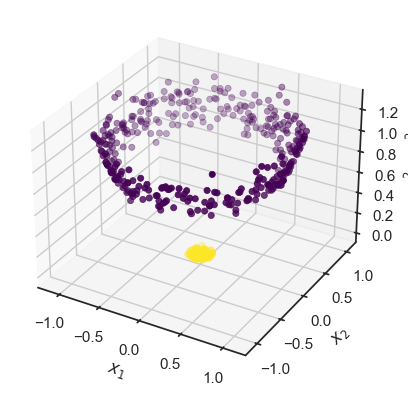

In [39]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(PHI_train[:,0], PHI_train[:,1],  PHI_train[:,2], c=y_train, cmap='viridis', linewidth=0.5);
ax.set_xlabel('$x_{1}$')
ax.set_ylabel('$x_{2}$')
ax.set_zlabel('$x_{1}^2+x_{2}^2$')
plt.show()

That looks like it would be possible to separate with a linear function! In 2D we would need a line to separate sections of space, but in 3D we need a plane. There are plenty of ways to draw a plane that divides up the purple and yellow datapoints. 

Let's check what this looks like by applying PCA to our enhanced dataset.

Projected onto the largest component, this shows a clear separation of the data.

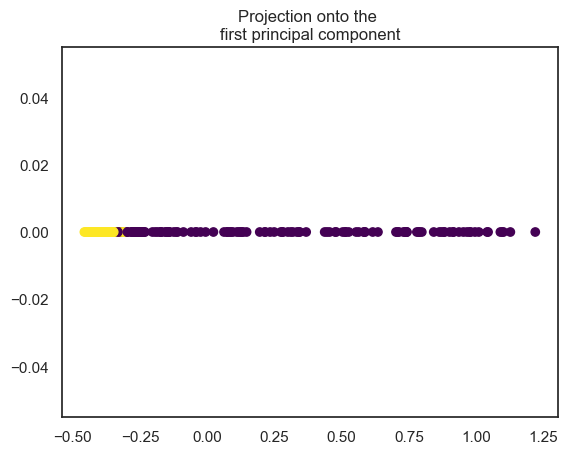

In [51]:
pca = PCA(n_components=3)
score_poly = pca.fit(PHI_train).transform(PHI_test)

plt.scatter(score_poly[:,0], np.zeros(score_poly[:,0].shape[0]), c=y_test, cmap='viridis')
plt.title("Projection onto the \nfirst principal component")
plt.show()

And projected onto the first two components:

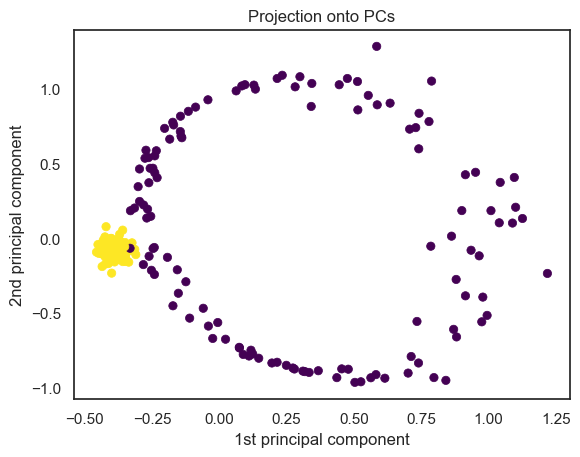

In [ ]:
plt.scatter(score_poly[:,0], score_poly[:,1], c=y_test, cmap='viridis', linewidth=0.5);
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.title("Projection onto PCs")
plt.show()

When we now fit a logistic model to the data, the model is able to perfectly distinguish the different clusters.

In [52]:
lr= LogisticRegression().fit(PHI_train, y_train)
print(f"Test set  mean accuracy score for for Kernal PCA: {lr.score(PHI_test, y_test)}")

Test set  mean accuracy score for for Kernal PCA: 1.0


For this example it is easy to find a kernel that works since there is a clear symmetry. But for the general case, simply adding polynomial features becomes very expensive. Therefore we apply the kernel trick to improve the computation of the algorithm as stated this way.

## Kernel PCA

The advantage of this trick is that we can create many different kernels, describing certain vector spaces. An often used kernel is the *rbf* (radial basis function) kernel, which is a measure of distance, with it's value decreasing with increasing distance. This way points that are close (or similar) get weighted more strongly.

This is a natural function to use for grouping like points together in higher dimensional space and since we only need to know the result of the inner product (or distance) of two points, we can use this as a kernel.

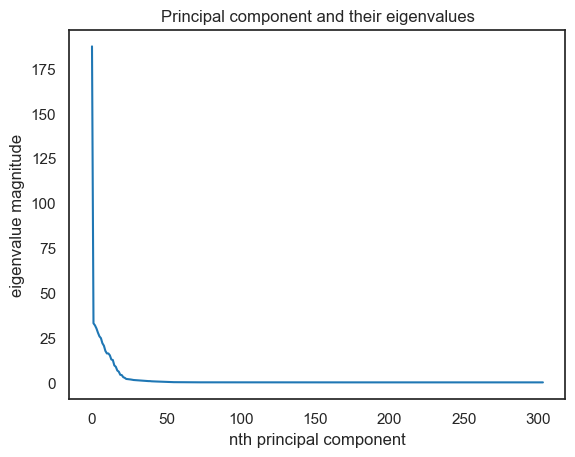

In [53]:
kernel_pca = KernelPCA(kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1)
kernel_pca.fit(X_train)
score_kernel_pca = kernel_pca.transform(X_test)

plt.plot(kernel_pca.eigenvalues_)

plt.title("Principal component and their eigenvalues")
plt.xlabel("nth principal component")
plt.ylabel("eigenvalue magnitude")
plt.show()

From this we can see that most of the variance is explained by the first few components, we can also see this by plotting the first two components of the transformed data against each other.

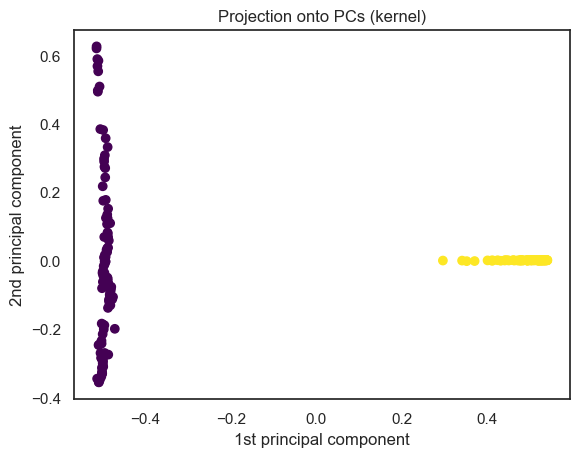

In [69]:
plt.scatter(score_kernel_pca[:,0], score_kernel_pca[:,1], c=y_test, cmap='viridis')
plt.title("Projection onto PCs (kernel)")
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.show()

Plotting the second and third components against each other, we can already see dome mixing of the clusters.

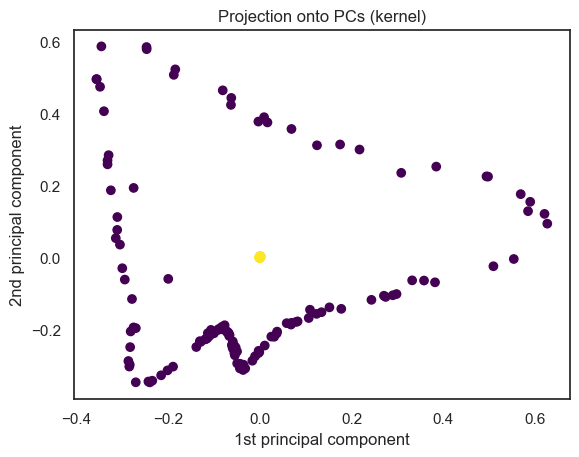

In [70]:
plt.scatter(score_kernel_pca[:,1], score_kernel_pca[:,2], c=y_test, cmap='viridis')
plt.title("Projection onto PCs (kernel)")
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.show()

You can try to think what this would look like in 3D, which is plotted below for context. Higher dimensions would be very hard to visualise, but from these plots it is clear that the first two dimensions are the most important.

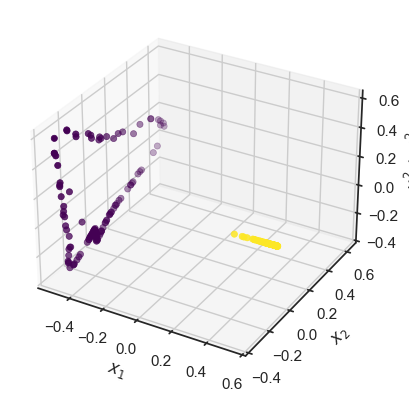

In [75]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(
    score_kernel_pca[:,0], 
    score_kernel_pca[:,1], 
    score_kernel_pca[:,2], 
    c=y_test, 
    cmap='viridis', 
    linewidth=0.5);
ax.set_xlabel('$x_{1}$')
ax.set_ylabel('$x_{2}$')
ax.set_zlabel('$x_{1}^2+x_{2}^2$')
plt.show()

One thing to be mindful of, kernel PCA does not always reconstruct the data exactly on an inverse transform. This is because only a subspace of the vector space described by $\Phi$. Since we only use the inner product, we lose some information about $\Phi$ in the process.

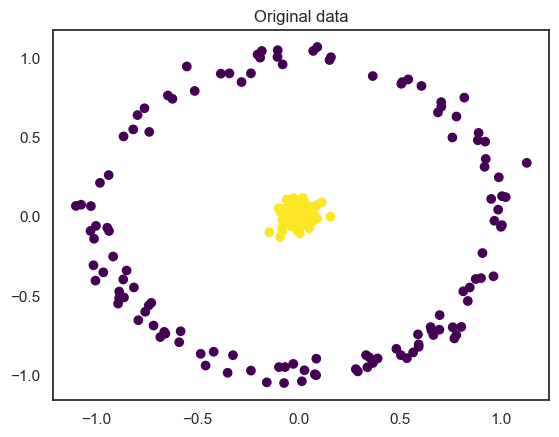

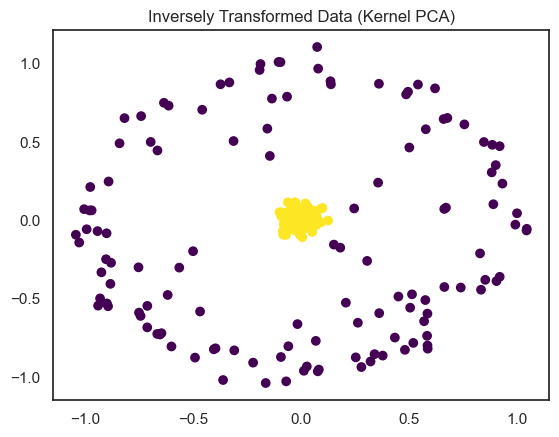

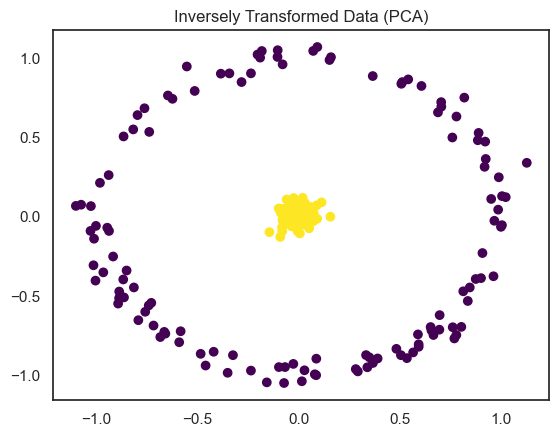

In [76]:
X_hat_kpca = kernel_pca.inverse_transform(kernel_pca.transform(X_test))

pca = PCA(n_components=2)
pca.fit(X_train)
X_hat_pca = pca.inverse_transform(pca.transform(X_test))

plt.scatter(X_test[:,0],X_test[:,1] ,c=y_test,cmap='viridis')
plt.title("Original data")
plt.show()

plt.scatter(X_hat_kpca[:,0],X_hat_kpca[:,1] ,c=y_test,cmap='viridis')
plt.title("Inversely Transformed Data (Kernel PCA)")
plt.show()

plt.scatter(X_hat_pca[:,0],X_hat_pca[:,1] ,c=y_test,cmap='viridis')
plt.title("Inversely Transformed Data (PCA)")
plt.show()

In [77]:
print("Mean squared error for Kernel PCA is:",((X_test-X_hat_kpca)**2).mean())
print("Mean squared error PCA is:" ,((X_test-X_hat_pca)**2).mean())

Mean squared error for Kernel PCA is: 0.011275231727822991
Mean squared error PCA is: 9.035257335900515e-33


## Prediction World Billionaires

We'll use data from Forbes, ranking the richest people in the world.

The features available from the dataset are:

*   Rank
*   Name
*   Net Worth - their net worth in billions USD
*   Age
*   Country
*   Source - their source of income
*   Industry - sector/industry/market segment in which each billionaire has made their fortune

In [105]:
df = pl.read_csv("./data/billionaires.csv").drop(ps.first())
df.head()

rank,name,networth,age,country,source,industry
i64,str,str,i64,str,str,str
1,"""Elon Musk ""","""$219 B""",50,"""United States""","""Tesla, SpaceX""","""Automotive """
2,"""Jeff Bezos ""","""$171 B""",58,"""United States""","""Amazon""","""Technology """
3,"""Bernard Arnault & family ""","""$158 B""",73,"""France""","""LVMH""","""Fashion & Retail """
4,"""Bill Gates ""","""$129 B""",66,"""United States""","""Microsoft""","""Technology """
5,"""Warren Buffett ""","""$118 B""",91,"""United States""","""Berkshire Hathaway""","""Finance & Investments """


In [106]:
df.shape

(2600, 7)

In [107]:
pl.DataFrame({
    "column": df.columns,
    "n_unique": [
        df.select(pl.col(c).n_unique()).item()
        for c in df.columns
    ],
})

column,n_unique
str,i64
"""rank""",228
"""name""",2598
"""networth""",228
"""age""",76
"""country""",75
"""source""",895
"""industry""",18


Interestingly, there are much more datapoints (2600) than there are ranks (228), which is explained by the fact that there are many ties present in the dataset. Also, there are a lot of names and sources, which represent unique people or organisations. So they are unlikely to help in predicting the rank.

Let's plot the distribution of the other categorical variables.

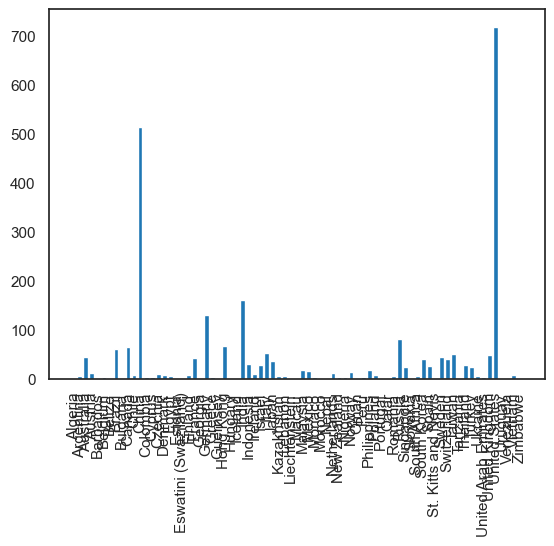

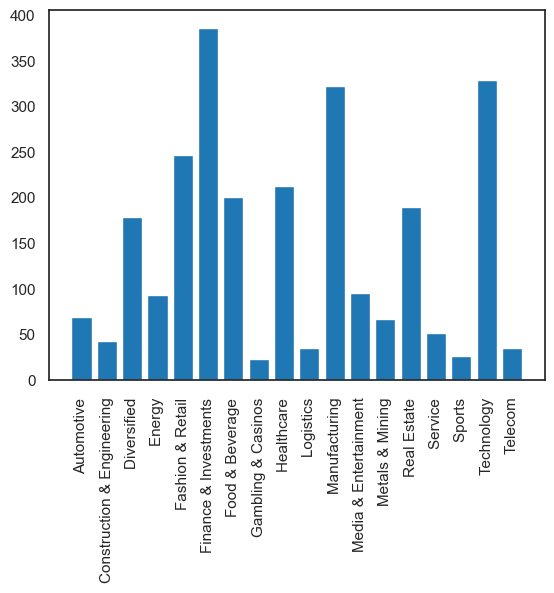

In [119]:
for column in ["country", "industry"]:
    counts = (
        df.select(column)
          .group_by(column)
          .len()
          .sort(column)
    )

    plt.bar(counts[column], counts["len"])
    plt.xticks(rotation="vertical")
    plt.show()

So alot of the billionaires are concentrated in USA and China. Also, Technology, Fiannce and Manufacturing have the most billionaires.

age,rank
f64,f64
1.0,-0.124947
-0.124947,1.0


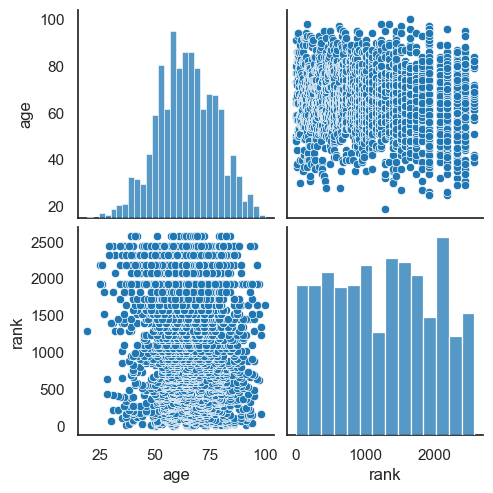

In [121]:
sns.pairplot(df[['age','rank']].to_pandas())
df[['age','rank']].corr()

In [122]:
B_names,networths,sources,industrys=df['name'],df['networth'],df['source'],df['industry']
B_names,networths,sources,industrys

(shape: (2_600,)
 Series: 'name' [str]
 [
 	"Elon Musk "
 	"Jeff Bezos "
 	"Bernard Arnault & family "
 	"Bill Gates "
 	"Warren Buffett "
 	…
 	"Jorge Gallardo Ballart "
 	"Nari Genomal "
 	"Ramesh Genomal "
 	"Sunder Genomal "
 	"Horst-Otto Gerberding "
 ],
 shape: (2_600,)
 Series: 'networth' [str]
 [
 	"$219 B"
 	"$171 B"
 	"$158 B"
 	"$129 B"
 	"$118 B"
 	…
 	"$1 B"
 	"$1 B"
 	"$1 B"
 	"$1 B"
 	"$1 B"
 ],
 shape: (2_600,)
 Series: 'source' [str]
 [
 	"Tesla, SpaceX"
 	"Amazon"
 	"LVMH"
 	"Microsoft"
 	"Berkshire Hathaway"
 	…
 	"pharmaceuticals"
 	"apparel"
 	"apparel"
 	"garments"
 	"flavors and fragrances"
 ],
 shape: (2_600,)
 Series: 'industry' [str]
 [
 	"Automotive "
 	"Technology "
 	"Fashion & Retail "
 	"Technology "
 	"Finance & Investments "
 	…
 	"Healthcare "
 	"Fashion & Retail "
 	"Fashion & Retail "
 	"Fashion & Retail "
 	"Food & Beverage "
 ])

### Fitting

Now we know a bit more about the data we can set up feature and target datasets and prepare the model.

In [174]:
target = "rank"
features = ["age", "country", "industry", "rank"]

y = df[target]
X = df[features]
X.head()

age,country,industry,rank
i64,str,str,i64
50,"""United States""","""Automotive """,1
58,"""United States""","""Technology """,2
73,"""France""","""Fashion & Retail """,3
66,"""United States""","""Technology """,4
91,"""United States""","""Finance & Investments """,5


Since we have mostly categrical features, we need to encode them first.

In [175]:
X_dummied = X.to_dummies(['country', 'industry'])
X_dummied.head()

age,country_Algeria,country_Argentina,country_Australia,country_Austria,country_Barbados,country_Belgium,country_Belize,country_Brazil,country_Bulgaria,country_Canada,country_Chile,country_China,country_Colombia,country_Cyprus,country_Czechia,country_Denmark,country_Egypt,country_Estonia,country_Eswatini (Swaziland),country_Finland,country_France,country_Georgia,country_Germany,country_Greece,country_Guernsey,country_Hong Kong,country_Hungary,country_Iceland,country_India,country_Indonesia,country_Ireland,country_Israel,country_Italy,country_Japan,country_Kazakhstan,country_Lebanon,…,country_South Africa,country_South Korea,country_Spain,country_St. Kitts and Nevis,country_Sweden,country_Switzerland,country_Taiwan,country_Tanzania,country_Thailand,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Venezuela,country_Vietnam,country_Zimbabwe,industry_Automotive,industry_Construction & Engineering,industry_Diversified,industry_Energy,industry_Fashion & Retail,industry_Finance & Investments,industry_Food & Beverage,industry_Gambling & Casinos,industry_Healthcare,industry_Logistics,industry_Manufacturing,industry_Media & Entertainment,industry_Metals & Mining,industry_Real Estate,industry_Service,industry_Sports,industry_Technology,industry_Telecom,rank
i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i64
50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2
73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3
66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4
91,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5


In [176]:
kernel_pca = KernelPCA(kernel="rbf" ,fit_inverse_transform=True, alpha=0.1)
kernel_score = kernel_pca.fit_transform(X_dummied)

Having fit a PCA model and transformed the input dataset, we can now check how this relates to the first two components. 

The analysis below shows that there is a clear direction in the components. There are a bunch of claerly defined lines in the graph, showing that PCA was able to linearise our dataset.

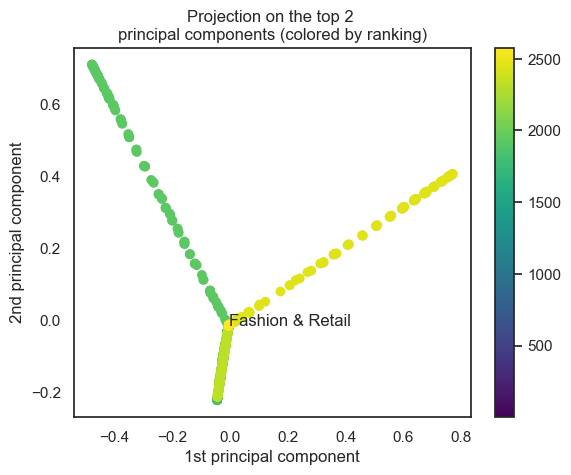

In [177]:
ranking = 15

fig, ax = plt.subplots()

sc=ax.scatter(kernel_score[:,0], kernel_score[:,1], c=y, cmap='viridis')
fig.colorbar(sc, orientation='vertical')
ax.annotate(industrys[ranking], (kernel_score[ranking,0],kernel_score[ranking,1]))
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.title("Projection on the top 2 \nprincipal components (colored by ranking)")
plt.show()

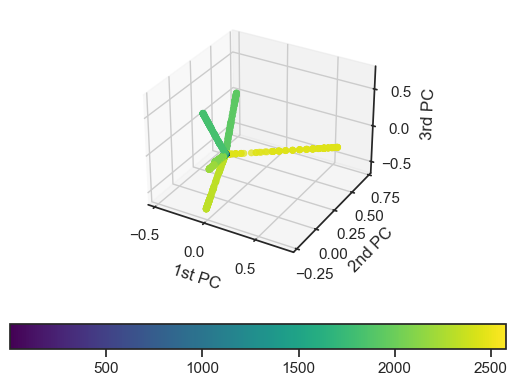

In [178]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc=ax.scatter(kernel_score[:,0], kernel_score[:,1],  kernel_score[:,2], c=y, cmap='viridis', linewidth=0.5);
fig.colorbar(sc, orientation='horizontal')
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
plt.show()

In [179]:
pca = PCA()
score_pca = pca.fit_transform(X_dummied)

Even using standard PCA, we can see that there is a clear directionality, with rank varying predictable along the x-axis.

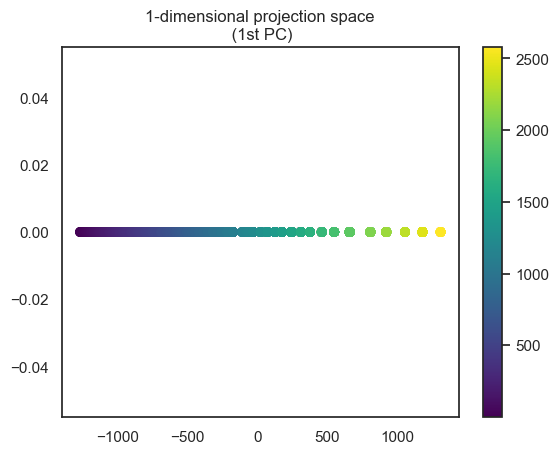

In [180]:
fig, ax = plt.subplots()
sc=ax.scatter(score_pca[:,0],np.zeros(score_pca[:,1].shape ),c=y,cmap='viridis')
ax.set_title('1-dimensional projection space\n (1st PC)')
fig.colorbar(sc, orientation='vertical')
plt.show()

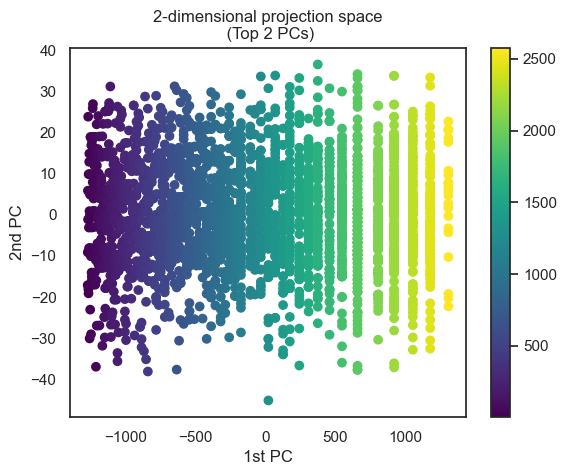

In [181]:
fig, ax = plt.subplots()
sc=ax.scatter(score_pca[:,0],score_pca[:,1] ,c=y,cmap='viridis')
fig.colorbar(sc, orientation='vertical')
ax.set_title('2-dimensional projection space\n (Top 2 PCs)')
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.show()

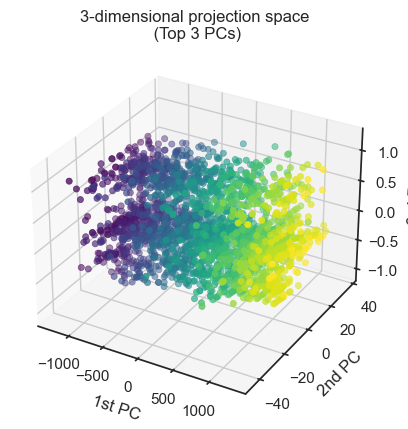

In [182]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc=ax.scatter(score_pca[:,0], score_pca[:,1],  score_pca[:,2], c=y, cmap='viridis', linewidth=0.5);
ax.set_title('3-dimensional projection space\n (Top 3 PCs)')
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
plt.show()

Though due to the nature of PCA, we don't know which combination of components gives th prediciton of rank, it is clear that at least *some* combination is predictive of rank.

## Kernel PCA for image denoising

PCA is a kind of natural denoising algorithm (essentially filtering with a low_pass filter). This is because the components are weighted sums of all datapoints, which automatically grabs common features of the data. So on image datasets that contain many similar images, it is easy to extract the commonalities and reconstruct the images from those common factors. We've also seen this with the eigenfaces in the previous notebook.

This is what happens below by applying the transform to a lower dimensional space (rewriting each image into a lower dimension, selecting only the most important features), and then inversely transforming the images back into the original feature space.

High frequency information (and noise) gets left behind by the transformation.

In [183]:
X_train_noisy = pd.read_csv('./data/X_train_noisy.csv').to_numpy()
X_test_noisy = pd.read_csv('./data/X_test_noisy.csv').to_numpy()

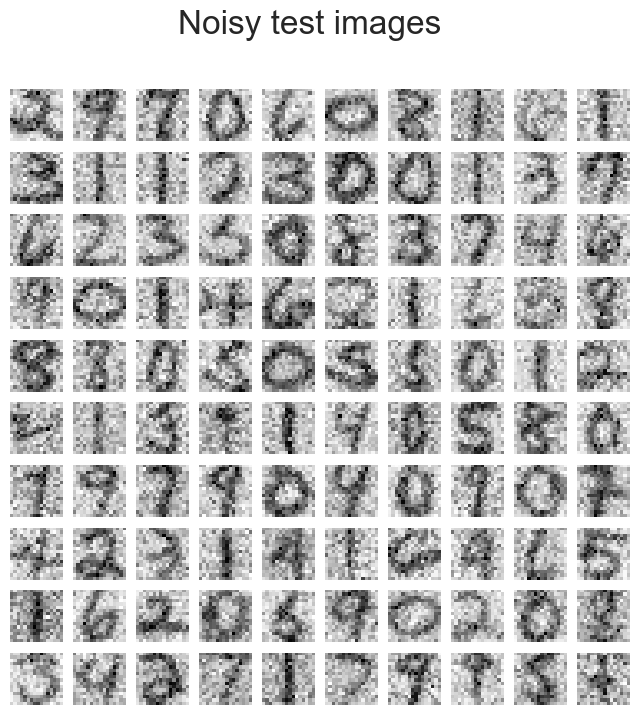

In [184]:
# Helper function for plotting the digit images
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)
    
plot_digits(X_test_noisy, "Noisy test images")

In [196]:
pca = PCA(n_components=35)
pca.fit(X_train_noisy)

kernel_pca = KernelPCA(n_components=400, kernel="rbf", gamma=0.01, fit_inverse_transform=True, alpha=0.1)
kernel_pca.fit(X_train_noisy)

,n_components,400
,kernel,'rbf'
,gamma,0.01
,degree,3
,coef0,1
,kernel_params,None
,alpha,0.1
,fit_inverse_transform,True
,eigen_solver,'auto'
,tol,0
,max_iter,None


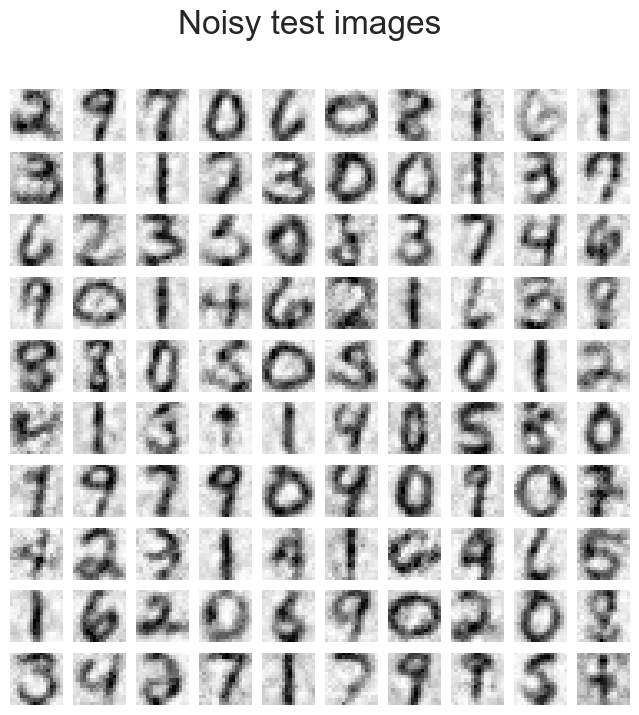

In [197]:
X_hat_test_noisy = pca.inverse_transform(pca.transform(X_test_noisy))
plot_digits(X_hat_test_noisy, "Noisy test images")

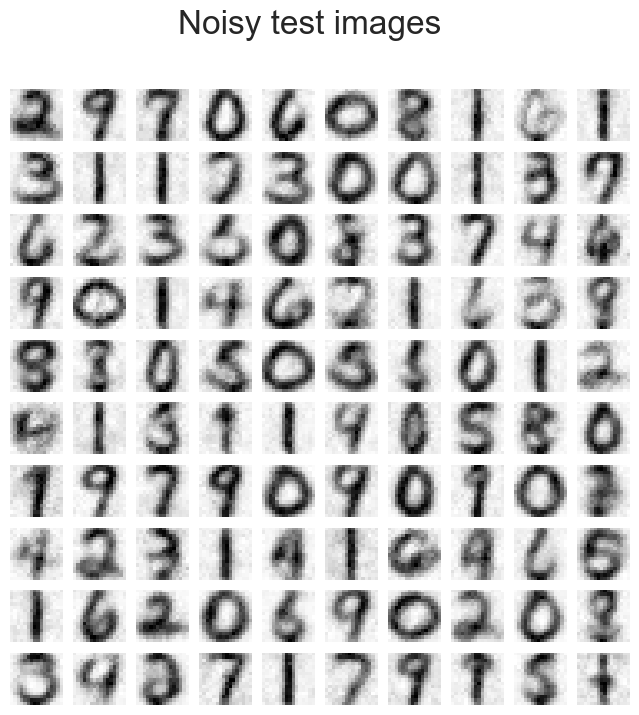

In [198]:
X_hat_test_noisy = kernel_pca.inverse_transform(kernel_pca.transform(X_test_noisy))
plot_digits(X_hat_test_noisy, "Noisy test images")